In [1]:
!pip install -q extra_keras_datasets

In [2]:
!pip freeze | grep -i "tensorflow\|keras"
!python -V

extra-keras-datasets==1.2.0
Keras==2.4.3
Keras-Preprocessing==1.1.2
keras-tuner==1.0.2
keras-vis==0.4.1
tensorflow==2.3.0
tensorflow-addons==0.8.3
tensorflow-datasets==4.0.1
tensorflow-estimator==2.3.0
tensorflow-gcs-config==2.3.0
tensorflow-hub==0.10.0
tensorflow-metadata==0.25.0
tensorflow-privacy==0.2.2
tensorflow-probability==0.11.0
Python 3.6.9


In [3]:
!pip install -q keras-tuner

In [77]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop

import kerastuner as kt
import numpy as np

import sklearn
from matplotlib import pyplot as plt
from extra_keras_datasets import emnist
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import tabulate
from IPython.display import display, Markdown, Latex, HTML

In [38]:
(input_train, target_train), (input_test, target_test) = emnist.load_data(type='byclass')

INFO:root:Loading dataset = emnist


In [40]:
MAPPING = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69,
           70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
           85, 86, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103, 104,
           105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
           117, 118, 119, 120, 121, 122]

In [41]:
WIDTH, HEIGHT = input_train[0].shape
CLASSES = np.unique(target_test).size

print(f"Number of classes = {CLASSES}")
print(f"WxH = {WIDTH}x{HEIGHT}")

Number of classes = 62
WxH = 28x28


In [42]:
input_train = input_train.astype('float32') / 255
input_test = input_test.astype('float32') / 255

In [43]:
input_train.shape, input_test.shape

((697932, 28, 28), (116323, 28, 28))

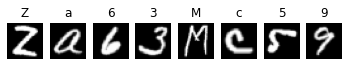

In [44]:
plotting = 8
for i in range(plotting):
    plt.subplot(1, plotting, i + 1)
    plt.axis('off')
    plt.imshow(input_train[i], cmap='gray')
    plt.title(chr(MAPPING[target_train[i]]))

In [45]:
input_train = np.reshape(input_train, (-1, HEIGHT, WIDTH, 1))
input_test = np.reshape(input_test, (-1, HEIGHT, WIDTH, 1))

In [46]:
target_train = keras.utils.to_categorical(target_train, CLASSES)
target_test = keras.utils.to_categorical(target_test, CLASSES)

In [47]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1)

In [48]:
def get_model(hp):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(HEIGHT, WIDTH, 1), activation='relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))

    if hp:
      model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    else:
      model.add(Dropout(0.5))
    model.add(Dense(CLASSES, activation='softmax'))

    metrics = [keras.metrics.TopKCategoricalAccuracy(k=3), keras.metrics.CategoricalAccuracy()]
    if hp:
      optimizer = optimizer=keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log'))
    else:
      optimizer = optimizer=keras.optimizers.Adam(learning_rate=3e-3)

    model.compile(loss='categorical_crossentropy', metrics=metrics, optimizer=optimizer)
    return model

In [15]:
tuner = kt.Hyperband(
    get_model,
    objective='val_categorical_accuracy',
    max_epochs=3,
    hyperband_iterations=2)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [16]:
stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1, min_lr=0.00001)

In [17]:
callbacks = [stopping, lr_reduction]

In [ ]:
tuner.search(input_train, target_train,
             validation_data=(input_test, target_test),
             epochs=3,
             callbacks=[callbacks])

In [18]:
model = get_model(None)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 128)      

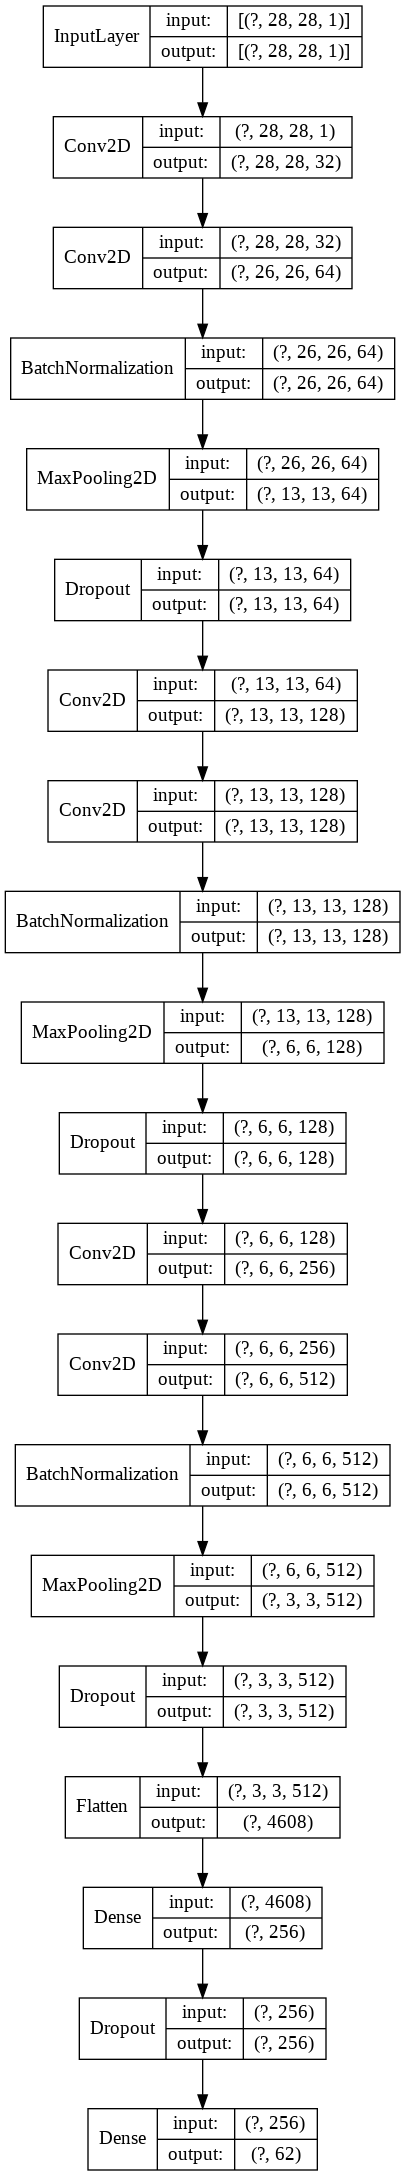

In [20]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [21]:
history = model.fit(input_train, target_train, validation_data=(input_test, target_test), callbacks=callbacks, batch_size=1024, epochs=10)

Epoch 1/10
  2/682 [..............................] - ETA: 55s - loss: 11.1155 - top_k_categorical_accuracy: 0.0757 - categorical_accuracy: 0.0215WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0567s vs `on_train_batch_end` time: 0.1065s). Check your callbacks.


682/682 [==============================] - 126s 185ms/step - loss: 1.2150 - top_k_categorical_accuracy: 0.8493 - categorical_accuracy: 0.6545 - val_loss: 0.4876 - val_top_k_categorical_accuracy: 0.9822 - val_categorical_accuracy: 0.8350
Epoch 2/10
682/682 [==============================] - 129s 190ms/step - loss: 0.5571 - top_k_categorical_accuracy: 0.9722 - categorical_accuracy: 0.8157 - val_loss: 0.4006 - val_top_k_categorical_accuracy: 0.9886 - val_categorical_accuracy: 0.8566
Epoch 3/10
682/682 [==============================] - 130s 190ms/step - loss: 0.4661 - top_k_categorical_accuracy: 0.9821 - categorical_accuracy: 0.8412 - val_loss: 0.3813 - val_top_k_categorical_accuracy: 0.9904 - val_categorical_accuracy: 0.8639
Epoch 4/10
682/682 [==============================] - 130s 190ms/step - loss: 0.4219 - top_k_categorical_accuracy: 0.9864 - categorical_accuracy: 0.8531 - val_loss: 0.3640 - val_top_k_categorical_accuracy: 0.9915 - val_categorical_accuracy: 0.8672
Epoch 5/10
682/682 

In [22]:
def plot_results(history, key, title, size=(3, 2)):
  epochs = np.arange(1, len(history.history[key]) + 1)
  plt.figure(dpi=144)
  plt.title(title)
  plt.plot(epochs, history.history[key])
  plt.plot(epochs, history.history[f"val_{key}"])
  plt.ylabel(key)
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()
 

In [23]:
history.history.keys()

dict_keys(['loss', 'top_k_categorical_accuracy', 'categorical_accuracy', 'val_loss', 'val_top_k_categorical_accuracy', 'val_categorical_accuracy', 'lr'])

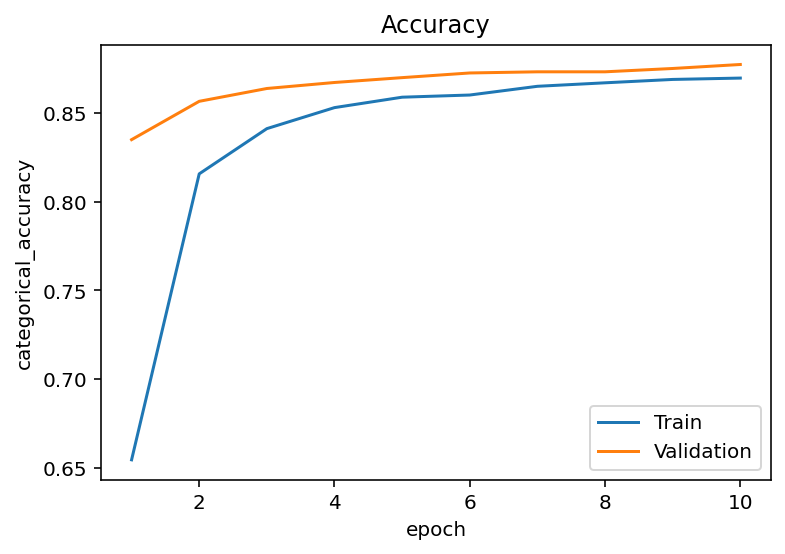

In [24]:
plot_results(history, "categorical_accuracy", "Accuracy")

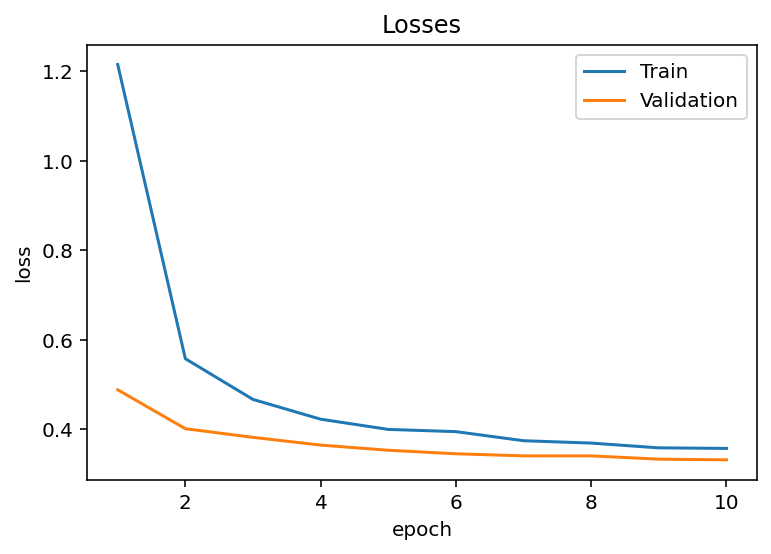

In [25]:
plot_results(history, "loss", "Losses")

In [26]:
model.save("Convolutional.h5")

In [60]:
def classification_report_(y_true, y_pred, labels=None, target_names=None,
                          sample_weight=None, digits=4, tablfmt='pipe'):
    floatfmt = '.{:}f'.format(digits)
    if labels is None:
        labels = sklearn.utils.multiclass.unique_labels(y_true, y_pred)
    else:
        labels = np.asarray(labels)

    if target_names is not None and len(labels) != len(target_names):
        print(
            "labels size, {0}, does not match size of target_names, {1}"
            .format(len(labels), len(target_names))
        )

    last_line_heading = 'avg / total'

    if target_names is None:
        target_names = [u'%s' % l for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None,
                                                  sample_weight=sample_weight)

    rows = zip(target_names, p, r, f1, s)
    tbl_rows = []
    for row in rows:
        tbl_rows.append(row)

    # compute averages
    last_row = (last_line_heading,
                np.average(p, weights=s),
                np.average(r, weights=s),
                np.average(f1, weights=s),
                np.sum(s))
    tbl_rows.append(last_row)
    return tabulate.tabulate(tbl_rows, headers=headers,
                    tablefmt=tablfmt, floatfmt=floatfmt)

In [61]:
classes = list(map(chr, MAPPING))
predicted = model.predict(input_test)
y_predicted = np.argmax(predicted, axis=1)

In [90]:
print(classification_report_(np.argmax(target_test, axis=-1), y_predicted, target_names=classes, tablfmt="github", digits=2))

|             |   precision |   recall |   f1-score |   support |
|-------------|-------------|----------|------------|-----------|
| 0           |        0.71 |     0.80 |       0.75 |   5778.00 |
| 1           |        0.68 |     0.93 |       0.79 |   6330.00 |
| 2           |        0.97 |     0.98 |       0.97 |   5869.00 |
| 3           |        1.00 |     0.99 |       1.00 |   5969.00 |
| 4           |        0.97 |     0.99 |       0.98 |   5619.00 |
| 5           |        0.98 |     0.93 |       0.95 |   5190.00 |
| 6           |        0.97 |     0.99 |       0.98 |   5705.00 |
| 7           |        0.99 |     1.00 |       0.99 |   6139.00 |
| 8           |        0.99 |     0.99 |       0.99 |   5633.00 |
| 9           |        0.93 |     0.99 |       0.96 |   5686.00 |
| A           |        0.96 |     0.99 |       0.97 |   1062.00 |
| B           |        0.95 |     0.97 |       0.96 |    648.00 |
| C           |        0.78 |     0.97 |       0.86 |   1739.00 |
| D       